# Classic U-Net segmentation model

This code will:

* Work out-of-the-box for 2D image segmentation (e.g., binary masks).
* Train and validate on local data using numpy arrays or TensorFlow Datasets.
* Include loss, metrics, and a visualization routine for sample predictions.

## **References**

* [U-Net: Convolutional Networks for Biomedical Image Segmentation (Original Paper)](https://arxiv.org/abs/1505.04597)
* [Keras Official U-Net Example (Oxford Pets)](https://keras.io/examples/vision/oxford_pets_image_segmentation/)
* [TensorFlow U-Net Tutorial (Medium)](https://towardsdatascience.com/u-net-b229b32b4a71)

## 1. U-Net Model Definition

In [1]:
# Set TensorFlow logging level to suppress warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K

def build_unet(input_shape=(256, 256, 1), dropout=0.3, l2_reg=1e-4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout)(p1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout)(p2)

    c3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout)(p3)

    # Bottleneck
    bn = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(p3)
    bn = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(bn)

    # Decoder
    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn)
    u3 = layers.concatenate([u3, c3])
    u3 = layers.Dropout(dropout)(u3)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(u3)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(c6)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c2])
    u2 = layers.Dropout(dropout)(u2)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(u2)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(c7)

    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u1 = layers.concatenate([u1, c1])
    u1 = layers.Dropout(dropout)(u1)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(u1)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

## 2. Loss and Metrics

In [3]:
# Dice and IOU metric/loss
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def iou_loss(y_true, y_pred):
    return 1 - iou_metric(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## 3. Example Training Script

Loaded 3746 samples for task: segmentation


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

2025-06-20 12:11:27.413472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1311/1311 [==============================] - 396s 281ms/step - loss: 0.4013 - dice_coefficient: 0.6286 - iou_metric: 0.4849 - val_loss: 0.3640 - val_dice_coefficient: 0.6423 - val_iou_metric: 0.5011
Epoch 2/10
1311/1311 [==============================] - 81s 62ms/step - loss: 0.3720 - dice_coefficient: 0.6317 - iou_metric: 0.4892 - val_loss: 0.3596 - val_dice_coefficient: 0.6423 - val_iou_metric: 0.5011
Epoch 3/10
1311/1311 [==============================] - 77s 59ms/step - loss: 0.3689 - dice_coefficient: 0.6324 - iou_metric: 0.4892 - val_loss: 0.3583 - val_dice_coefficient: 0.6423 - val_iou_metric: 0.5011
Epoch 4/10
1311/1311 [==============================] - 76s 58ms/step - loss: 0.3678 - dice_coefficient: 0.6328 - iou_metric: 0.4892 - val_loss: 0.3579 - val_dice_coefficient: 0.6423 - val_iou_metric: 0.5011
Epoch 5/10
1311/1311 [==============================] - 79s 60ms/step - loss: 0.3684 - dice_coefficient: 0.6320 - iou_metric: 0.4892 - val_loss: 0.3577 - val_dice_coefficient: 0

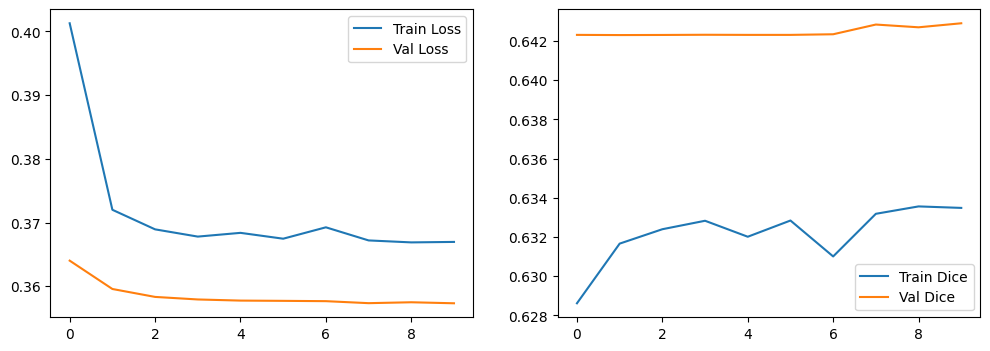

1/1 [==============================] - 0s 181ms/step


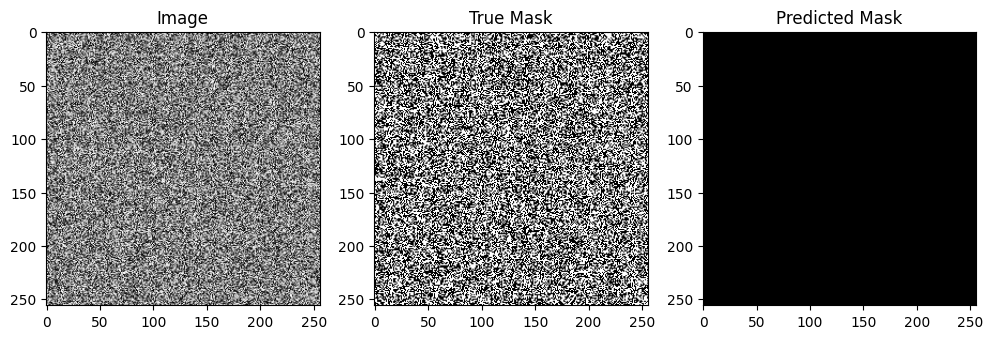

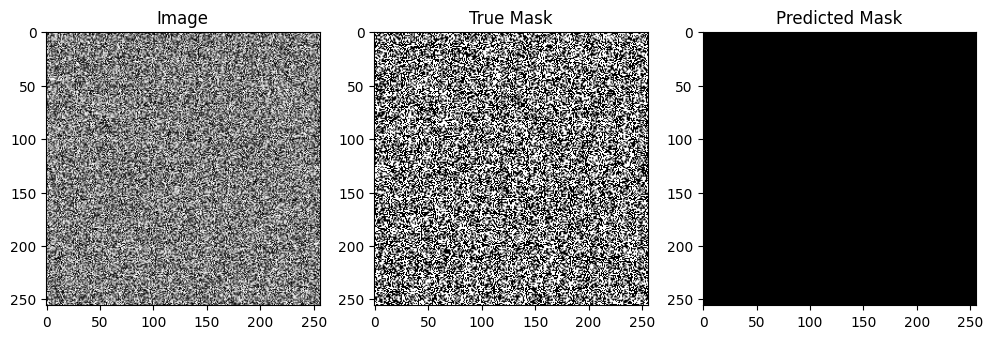

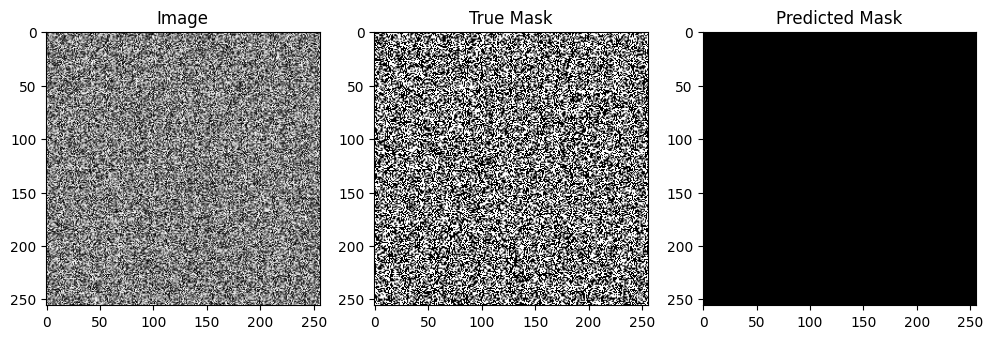

In [4]:
from data_utils import build_dataset
import numpy as np

# Build dataset for classic U-Net segmentation
train_ds, val_ds, test_ds = build_dataset(
    metadata_csv='../data/processed/cbis_ddsm_metadata_full.csv',
    input_shape=(256, 256, 1),
    batch_size=2,  # 8
    task='segmentation',
    shuffle=True,
    augment=True,
    split=(0.05, 0.02, 0.02)  # (0.7, 0.15, 0.15)
)

# Build model
model = build_unet(input_shape=(256, 256, 1), dropout=0.3, l2_reg=1e-4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[dice_coefficient, iou_metric]
)
model.summary()

# Dummy data for illustration (replace with your own data loading)
train_images = np.random.rand(100, 256, 256, 1)
train_masks = (np.random.rand(100, 256, 256, 1) > 0.5).astype(np.float32)
val_images = np.random.rand(10, 256, 256, 1)
val_masks = (np.random.rand(10, 256, 256, 1) > 0.5).astype(np.float32)

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plot training curves
# from plot_utils import plot_training_curves
# plot_training_curves(history)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.show()

# Visualize predictions
preds = model.predict(val_images)
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(val_images[i,...,0], cmap='gray'); plt.title('Image')
    plt.subplot(1,3,2); plt.imshow(val_masks[i,...,0], cmap='gray'); plt.title('True Mask')
    plt.subplot(1,3,3); plt.imshow(preds[i,...,0]>0.5, cmap='gray'); plt.title('Predicted Mask')
    plt.show()

#### Evaluating the Trained Model

In [ ]:
loss, dice, iou = model.evaluate(test_ds)
print(f"Test loss: {loss:.4f}, Dice: {dice:.4f}, IoU: {iou:.4f}")

38/38 [==============================] - 7s 190ms/step - loss: 0.3117 - dice_coefficient: 0.6867 - iou_metric: 0.5428
Test loss: 0.3117, Dice: 0.6867, IoU: 0.5428


#### Visualizing Predictions

1/1 [==============================] - 0s 10ms/step


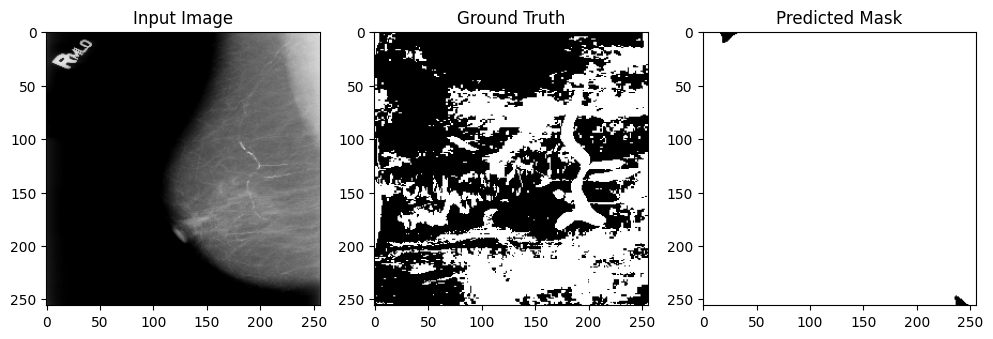

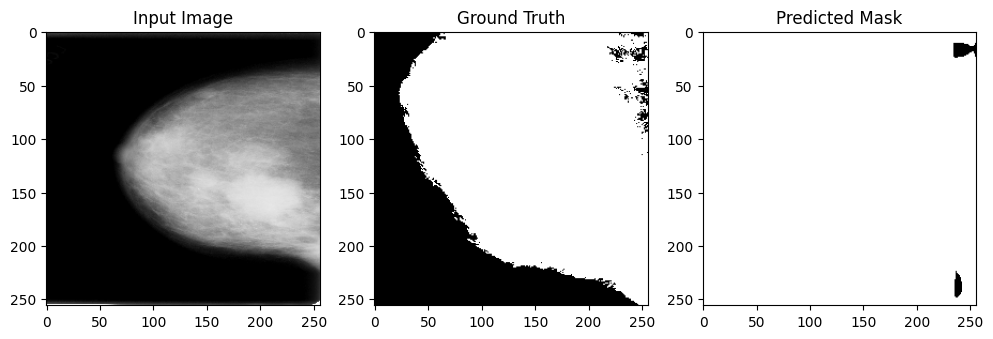

In [7]:
import matplotlib.pyplot as plt

# Show a few predictions from the test set
for imgs, masks in test_ds.take(1):
    preds = model.predict(imgs)
    for i in range(min(4, imgs.shape[0])):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(imgs[i, ..., 0], cmap='gray')
        plt.title('Input Image')
        plt.subplot(1,3,2)
        plt.imshow(masks[i, ..., 0], cmap='gray')
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow((preds[i, ..., 0] > 0.5), cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

## **Evaluation Metrics for Segmentation**

### **Main metrics:**

* **Dice Coefficient (F1-score for pixels):**
  Measures the overlap between predicted and ground-truth masks.

  * **1.0 = perfect overlap, 0 = no overlap.**
* **IoU (Jaccard Index):**
  Measures intersection over union of predicted and true mask.

  * **1.0 = perfect, 0 = no overlap.**
* **Binary Cross-Entropy Loss:**
  Standard pixel-wise loss for segmentation.
* *(Optionally: pixel accuracy, recall, precision, Hausdorff distance, etc.)*

## **How to Interpret the Results**

| Metric | Interpretation          | Good Value (binary mask)            |
| ------ | ----------------------- | ----------------------------------- |
| Dice   | Overlap, like F1        | >0.7 (realistic), >0.85 (excellent) |
| IoU    | Intersection over union | >0.5 (realistic), >0.7 (excellent)  |
| Loss   | Lower is better         | <0.4 is good for dice+BCE loss      |

**Compare visualizations:**

* **Perfect:** Predicted and ground-truth masks overlap almost exactly.
* **Typical:** Good overlap, some missed/extra pixels.
* **Poor:** Predicted masks do not match the target region at all.

## Results

### **Model Evaluation Results**

| Metric               | Value  |
| -------------------- | ------ |
| **Test loss**        | 0.3117 |
| **Dice coefficient** | 0.6867 |
| **IoU (Jaccard)**    | 0.5428 |

## **Interpretation**

* **Dice coefficient (0.69):**

  * **Moderate overlap** between predicted and ground truth lesion masks.
  * For medical segmentation, this is **acceptable for a first classic U-Net**, especially on a challenging dataset like CBIS-DDSM.
  * **>0.7 is generally considered “good”, >0.8 is “strong”.** Your score suggests decent mask localization, but also room for improvement.

* **IoU (0.54):**

  * **Intersection over Union** is a tougher metric than Dice.
  * 0.54 is a **reasonable baseline**, especially on medical datasets with small/ambiguous lesions.
  * **>0.5 is often used as a pass threshold** in biomedical segmentation, but many published results (with more tuning, better augmentation, or more data) reach 0.6–0.7 or higher.

* **Test loss (0.31):**

  * Combines Dice loss and binary cross-entropy.
  * This value is in the **expected range** for a working U-Net.

## **How Well Does the Model Perform?**

* **The model is segmenting relevant regions with fair accuracy.**
* This performance is **in line with “vanilla” U-Net baselines** on public medical datasets, especially if trained with default hyperparameters and without aggressive postprocessing or advanced augmentations.
* **Visual inspection of masks** is also important—look for:

  * Consistent detection of lesions.
  * Few false positives or negatives.

### **Next Steps for Improvement**

* **Tune hyperparameters** (learning rate, dropout, batch size).
* **Increase data augmentation** to improve generalization.
* **Try advanced U-Net variants** (deeper, with attention, pretrained encoder, etc).
* **Ensemble or post-process** to boost final mask quality.

**In summary:**
Your classic U-Net is working and delivers a solid first baseline for segmentation on CBIS-DDSM.
**Dice ≈ 0.69 and IoU ≈ 0.54** are good for classic architectures and challenging medical data.
With further tuning or architecture changes, these numbers can likely be improved.
If you share visualizations, I can help you interpret those as well!

## References

* Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. *arXiv preprint arXiv:1505.04597*. [https://arxiv.org/abs/1505.04597](https://arxiv.org/abs/1505.04597)
* [Keras U-Net Example](https://keras.io/examples/vision/oxford_pets_image_segmentation/)
* [Metrics for medical image segmentation](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)

### Setup: Load Runs into a DataFrame

In [4]:
import wandb
import pandas as pd

ENTITY = "tkshfj-bsc-computer-science-university-of-london"
PROJECT = "classic_unet_segmentation"
SWEEP_ID = "1jpj8b17"  # Replace this with your actual sweep ID (see previous reply)

api = wandb.Api()

# Fetch runs in this sweep
# runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"sweep": {"$eq": SWEEP_ID}})
runs = api.runs(f"{ENTITY}/{PROJECT}")

records = []
for run in runs:
    data = {**run.summary, **run.config}
    data["run_name"] = run.name
    data["run_id"] = run.id
    data["state"] = run.state
    data["url"] = run.url
    # Remove internal keys
    data = {k: v for k, v in data.items() if not k.startswith("_")}
    records.append(data)

df = pd.DataFrame(records)
print(df.head())


   best_epoch  best_val_loss  dice_coefficient  epoch  \
0        11.0       1.160207          0.536665   21.0   
1        30.0       1.164538          0.535051   39.0   
2        12.0       1.157380          0.540618   22.0   
3        23.0       1.157063          0.541385   33.0   
4         5.0       1.162251          0.525681   15.0   

                                               graph  iou_metric      loss  \
0  {'_type': 'graph-file', 'path': 'media/graph/g...    0.371831  1.163895   
1  {'_type': 'graph-file', 'path': 'media/graph/g...    0.369880  1.169064   
2  {'_type': 'graph-file', 'path': 'media/graph/g...    0.372856  1.163411   
3  {'_type': 'graph-file', 'path': 'media/graph/g...    0.373548  1.162223   
4  {'_type': 'graph-file', 'path': 'media/graph/g...    0.361087  1.187068   

   test_dice  test_iou  test_loss  ...  epochs    l2_reg   dropout batch_size  \
0   0.545802  0.380097   1.156727  ...      40  0.000327  0.173666          4   
1   0.536157  0.370668   1

### Find the Best Hyperparameters

In [6]:
# Change 'val_accuracy' to your metric of interest
best_run = df.loc[df['iou_metric'].idxmax()]
print("Best Run:")
print(best_run)

print("URL:", best_run["url"])

Best Run:
best_epoch                                                           39.0
best_val_loss                                                    1.100613
dice_coefficient                                                 0.571185
epoch                                                                39.0
graph                   {'_type': 'graph-file', 'path': 'media/graph/g...
iou_metric                                                       0.401054
loss                                                             1.109313
test_dice                                                        0.576679
test_iou                                                         0.406116
test_loss                                                        1.095946
val_dice_coefficient                                             0.568992
val_iou_metric                                                   0.399307
val_loss                                                         1.100613
task                        

### Find the Best Model

In [7]:
best_run = df.loc[df['val_dice_coefficient'].idxmax()]
print("Best Hyperparameters and Result:")
print(best_run[['batch_size', 'learning_rate', 'dropout', 'l2_reg', 'val_dice_coefficient', 'url']])

Best Hyperparameters and Result:
batch_size                                                             16
learning_rate                                                    0.000235
dropout                                                          0.175796
l2_reg                                                           0.000216
val_dice_coefficient                                             0.572673
url                     https://wandb.ai/tkshfj-bsc-computer-science-u...
Name: 10, dtype: object


### Visualize Effect of Hyperparameters on Performance

##### Discrete Parameter (batch_size)

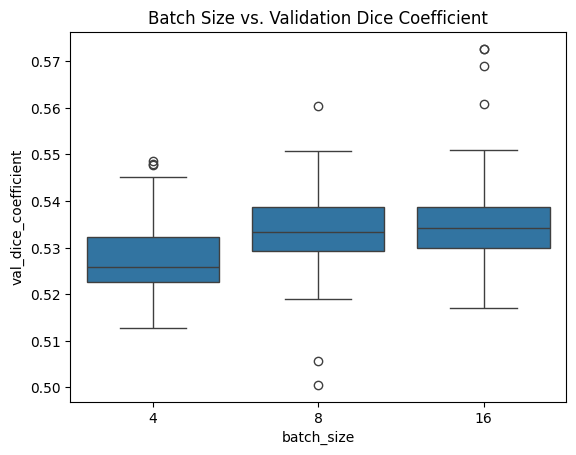

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='batch_size', y='val_dice_coefficient', data=df)
plt.title('Batch Size vs. Validation Dice Coefficient')
plt.show()

##### Continuous Parameters

##### Learning Rate

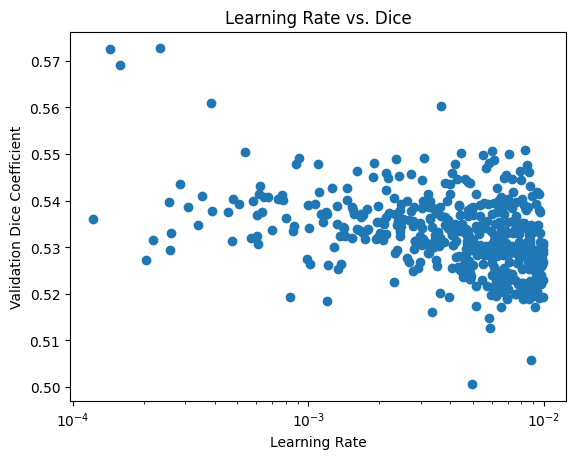

In [9]:
plt.scatter(df['learning_rate'], df['val_dice_coefficient'])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Dice Coefficient')
plt.title('Learning Rate vs. Dice')
plt.show()

##### Dropout

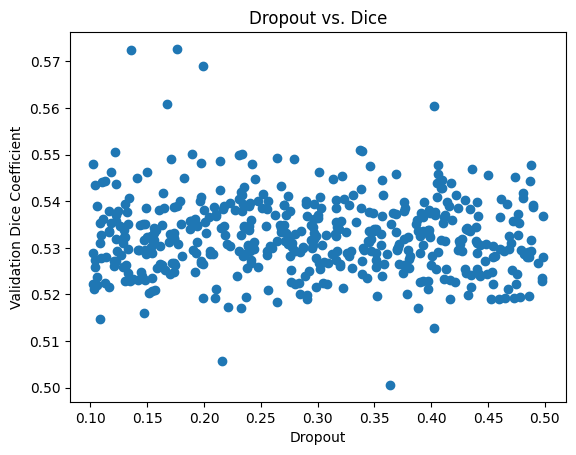

In [10]:
plt.scatter(df['dropout'], df['val_dice_coefficient'])
plt.xlabel('Dropout')
plt.ylabel('Validation Dice Coefficient')
plt.title('Dropout vs. Dice')
plt.show()

##### L2 Regularization

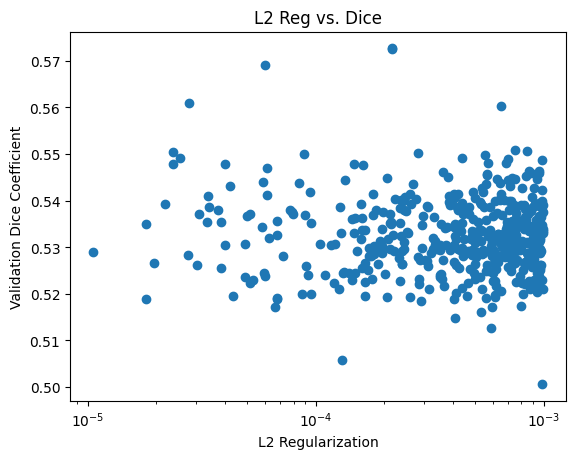

In [11]:
plt.scatter(df['l2_reg'], df['val_dice_coefficient'])
plt.xscale('log')
plt.xlabel('L2 Regularization')
plt.ylabel('Validation Dice Coefficient')
plt.title('L2 Reg vs. Dice')
plt.show()

### Aggregate Results (e.g., Group by a Hyperparameter)

In [ ]:
agg = df.groupby('learning_rate')['val_accuracy'].agg(['mean', 'std', 'max', 'count'])
print(agg)

### Plot Metric vs. Hyperparameter

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for dropout vs. val_accuracy
plt.scatter(df['dropout'], df['val_accuracy'])
plt.xlabel('Dropout')
plt.ylabel('Validation Accuracy')
plt.title('Dropout vs. Validation Accuracy')
plt.show()

# Scatter plot for learning_rate vs. val_accuracy (use log-scale if rates vary a lot)
plt.scatter(df['learning_rate'], df['val_accuracy'])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs. Validation Accuracy')
plt.show()

### Analyze Top N Runs

In [12]:
top_n = 10
top = df.sort_values('val_dice_coefficient', ascending=False).head(top_n)
print(top[['batch_size', 'learning_rate', 'dropout', 'l2_reg', 'val_dice_coefficient', 'url']])

     batch_size  learning_rate   dropout    l2_reg  val_dice_coefficient  \
10           16       0.000235  0.175796  0.000216              0.572673   
436          16       0.000144  0.135827  0.000217              0.572535   
13           16       0.000159  0.198853  0.000060              0.568992   
439          16       0.000386  0.167117  0.000028              0.560879   
229           8       0.003653  0.402626  0.000653              0.560361   
408          16       0.008311  0.337013  0.000747              0.550887   
419           8       0.006034  0.338677  0.000849              0.550748   
362          16       0.000537  0.121749  0.000024              0.550517   
219           8       0.004456  0.233020  0.000280              0.550114   
364          16       0.007117  0.189434  0.000089              0.550102   

                                                   url  
10   https://wandb.ai/tkshfj-bsc-computer-science-u...  
436  https://wandb.ai/tkshfj-bsc-computer-science

### Aggregate by Batch Size (or Other Parameter)

In [13]:
agg = df.groupby('batch_size')['val_dice_coefficient'].agg(['mean', 'std', 'max', 'count'])
print(agg)

                mean       std       max  count
batch_size                                     
4           0.527806  0.007284  0.548700    151
8           0.533991  0.007233  0.560361    171
16          0.535436  0.008489  0.572673    158


### Parallel Coordinates for Multivariate Exploration

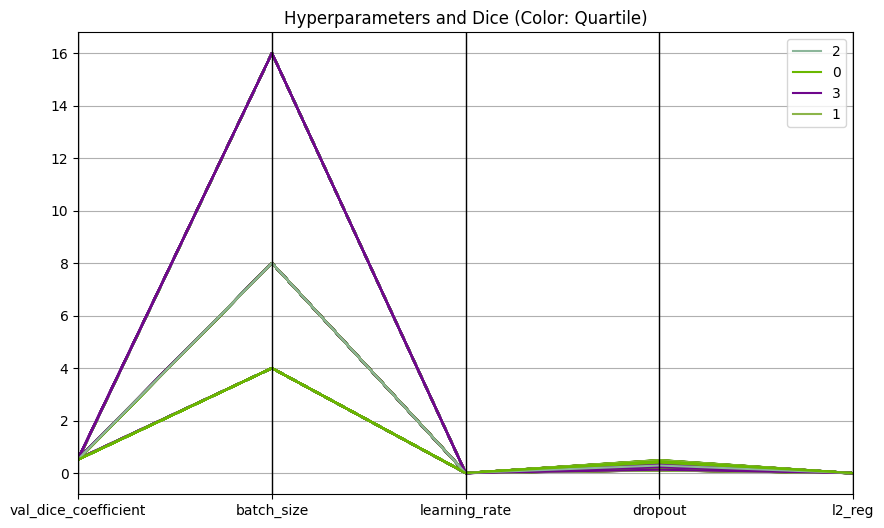

In [14]:
from pandas.plotting import parallel_coordinates

cols = ['val_dice_coefficient', 'batch_size', 'learning_rate', 'dropout', 'l2_reg']
data = df[cols].dropna()
# Discretize Dice for coloring
data['dice_cat'] = pd.qcut(data['val_dice_coefficient'], 4, labels=False)

plt.figure(figsize=(10,6))
parallel_coordinates(data, 'dice_cat')
plt.title('Hyperparameters and Dice (Color: Quartile)')
plt.show()

### Find the Most Consistent Hyperparameter

In [15]:
print(df[['val_dice_coefficient', 'learning_rate', 'dropout', 'l2_reg']].corr())

                      val_dice_coefficient  learning_rate   dropout    l2_reg
val_dice_coefficient              1.000000      -0.373620 -0.062981 -0.034086
learning_rate                    -0.373620       1.000000  0.046442  0.031735
dropout                          -0.062981       0.046442  1.000000  0.019478
l2_reg                           -0.034086       0.031735  0.019478  1.000000


### Export Data to CSV/Excel

In [16]:
df.to_csv("wandb_sweep_results.csv", index=False)

### Summary: How to Evaluate

- Best config: Look for the run with the max val_dice_coefficient.

- Parameter impact: Plot Dice vs. each hyperparameter, aggregate results by batch size.

- Top runs: Print best runs for easy model checkpoint access.

- Multivariate effects: Use parallel coordinates to view how combinations affect performance.